No handles with labels found to put in legend.
No handles with labels found to put in legend.


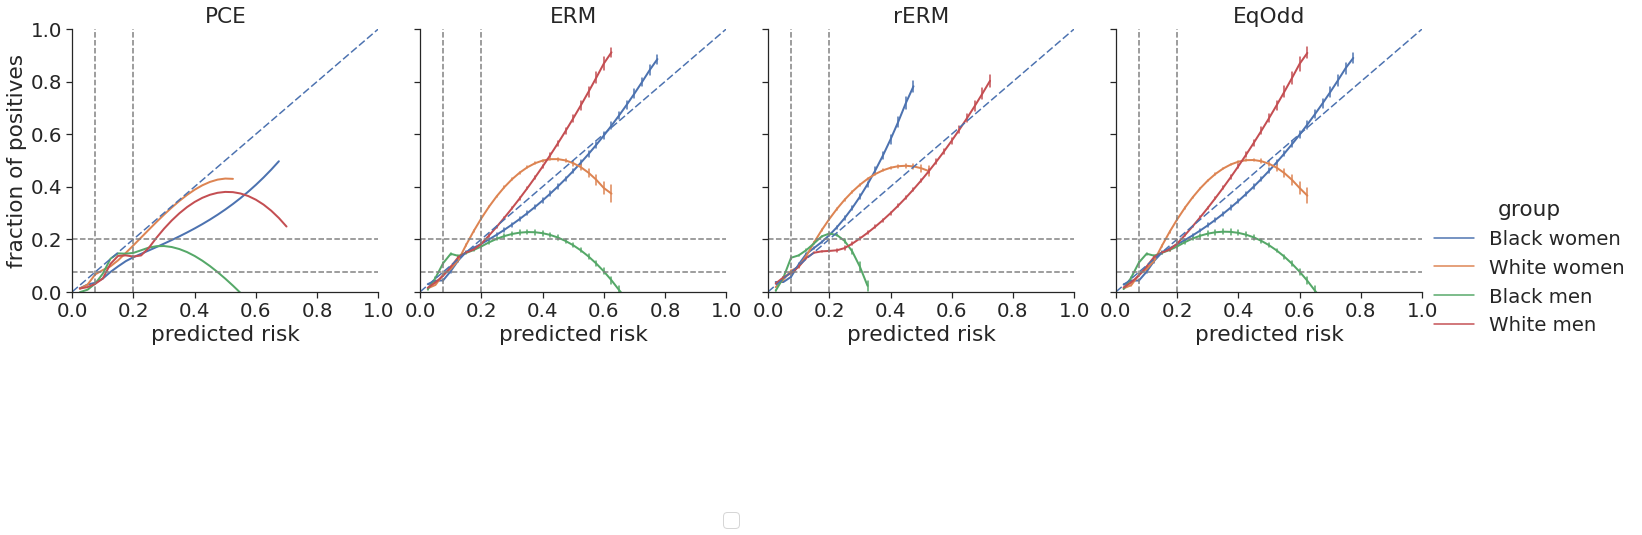

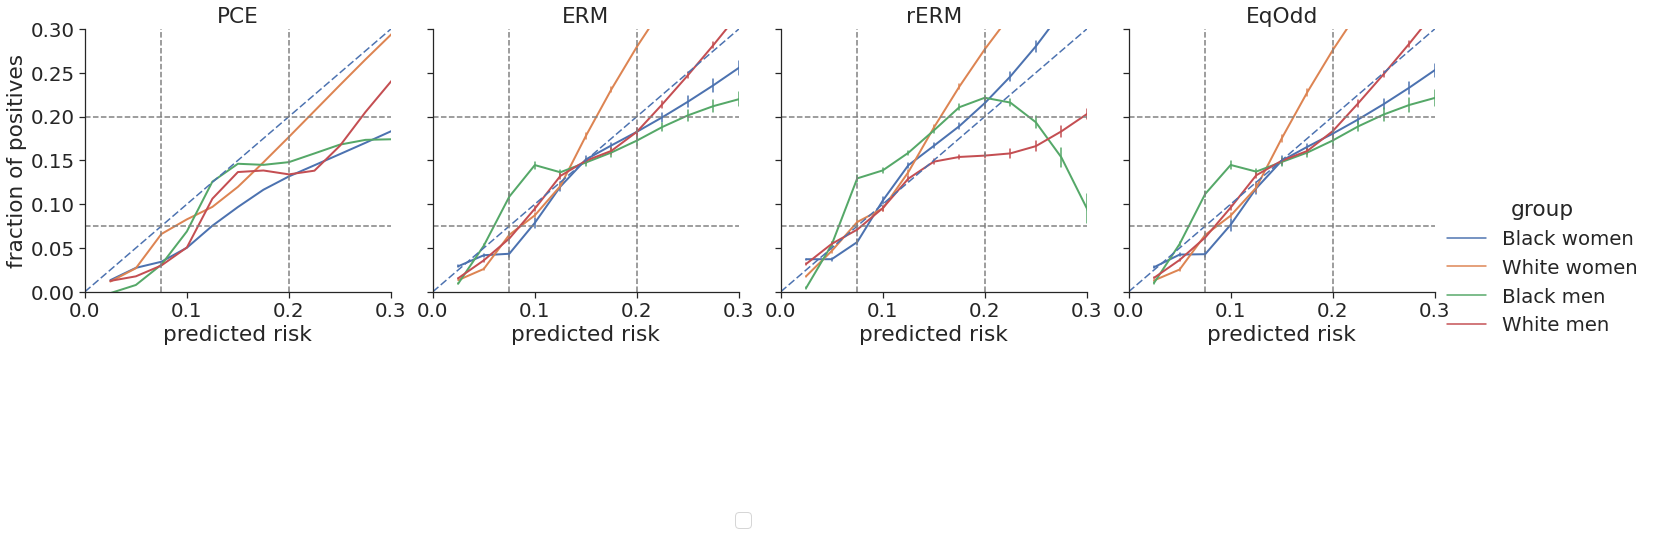

In [1]:
import pandas as pd
import os
import numpy as np
import logging
import sys
import torch
import copy
import yaml
import random

from prediction_utils.pytorch_utils.metrics import (
    StandardEvaluator,
    FairOVAEvaluator,
    CalibrationEvaluator
)

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
sns.set_style("ticks")


grp_label_dict = {1: 'Black women', 2: 'White women', 3: 'Black men', 4: 'White men'} 

args = {'cohort_path': '/labs/shahlab/projects/agataf/data/cohorts/pooled_cohorts/cohort/all_cohorts.csv',
        'base_path': '/labs/shahlab/projects/agataf/data/cohorts/pooled_cohorts',
        'grp_label_dict': {1: 'Black women', 2: 'White women', 3: 'Black men', 4: 'White men'},
        'plot_path': os.path.join('/labs/shahlab/projects/agataf/fairness_utility/eval/plots', 'paper_plots'),
        'eval_fold': 'test'
       }

eqodds_threshold = 0.01
calib_method = 'logx_logreg'


output_path = os.path.join(args['plot_path'], 'risk_category_counts.png')

def plot_calibration(calibration_df, zoom=False, output_path=None):  
    sns.set(font_scale=1.8)
    sns.set_style("ticks")
    df = calibs_all.assign(group = lambda x: x.group.map(grp_label_dict),
                           model_type = lambda x: x.model_type.map({'original_pce': 'PCE',
                                                                     'erm': 'ERM',
                                                                     'recalib_erm': 'rERM',
                                                                     'eqodds_mmd': 'EqOdd'}
                                                                   )
                          )
    g = sns.relplot(data = df,
                    x = 'pred_probs',
                    y = 'calibration_density',
                    kind = 'line',
                    hue = 'group',
                    col = 'model_type',
                    legend = True,
                    ci='sd',
                    err_style='bars',
                    aspect = 1,
                    linewidth = 2)
    
    g.set_titles(row_template="{row_name}", col_template="{col_name}")
    
    plt.legend(
               bbox_to_anchor=(-1.2, -0.8)
              )

    
    axes = g.axes.flatten()
    
    for ax in axes:
        ax.axline(xy1 = (0,0), slope = 1, color = "b", dashes = (5, 2), label = "Perfectly calibrated")
        ax.axvline(x = 0.075, linestyle = '--', color = 'grey')
        ax.axvline(x = 0.2,   linestyle = '--', color = 'grey')
        ax.axhline(y = 0.075, linestyle = '--', color = 'grey')
        ax.axhline(y = 0.2,   linestyle = '--', color = 'grey')

        if zoom:
            ax.set(xlim = (0, 0.3), ylim = (0, 0.3))
        else:
            ax.set(xlim = (0, 1), ylim = (0, 1))

        ax.set_xlabel("predicted risk")
        ax.set_ylabel("fraction of positives")
    
    
    if output_path is not None:
        g.savefig(output_path)
        
calibs_all = []

for experiment in ['original_pce', 'apr14_erm', 'apr14_erm_recalib', 'apr14_mmd']:

    aggregate_path = os.path.join(args['base_path'], 'experiments', 
                                      experiment, 'performance',
                                      'all', 'calibration', calib_method)
    
    lin_calibs = pd.read_csv(os.path.join(aggregate_path, 'calibration_sensitivity_test_raw.csv'))
    if experiment in ['apr14_mmd', 'apr14_thr']:
        lin_calibs = lin_calibs.query('model_id == @eqodds_threshold')
        
    if 'model_id' not in lin_calibs.columns:
        lin_calibs = lin_calibs.assign(model_id=0)
    calibs_all.append(lin_calibs)   
    
calibs_all = pd.concat(calibs_all)

output_path = os.path.join(args['plot_path'], '_'.join((calib_method,'calibrations.png')))
plot_calibration(calibs_all, zoom=False, output_path=output_path)

output_path = os.path.join(args['plot_path'], '_'.join((calib_method,'calibrations_zoom.png')))
plot_calibration(calibs_all, zoom=True, output_path=output_path)

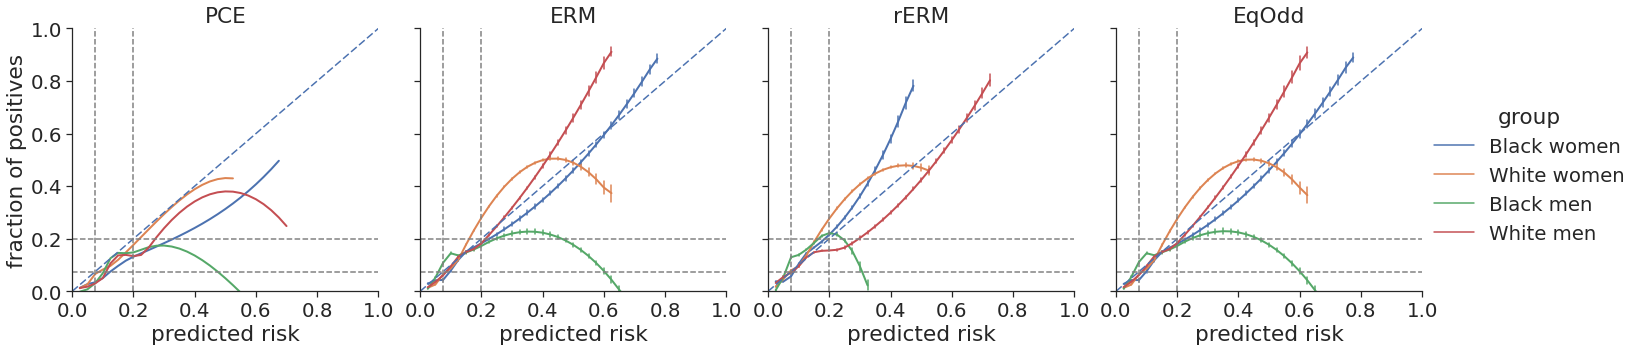

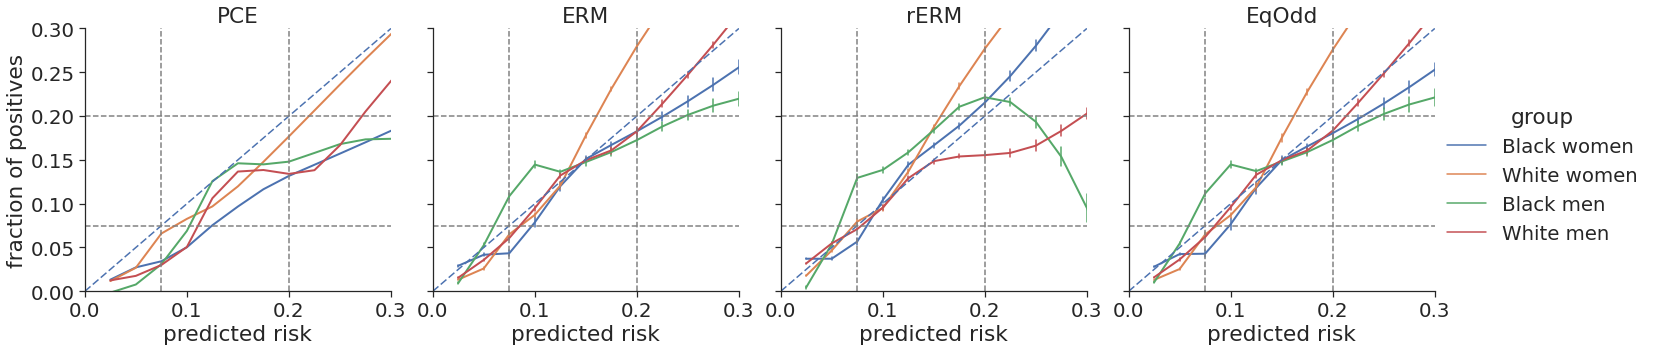